In [1]:
using Distributed
using Plots
using LaTeXStrings
using HDF5
using Statistics
using StatsBase
using Random
#addprocs(8)
@everywhere include("fluo_cont_meas_sim.jl")
@everywhere include("likelihood.jl")
@everywhere include("likelihood_strong.jl")
@everywhere include("fisher_cont_meas.jl")
include("load_data.jl")

sample_data_chunk

In [2]:
FILENAME = "089_exp=4_prepared.h5"

global file = h5open(FILENAME, "r")

HDF5 data file: 089_exp=4_prepared.h5

In [3]:
@time data = load_z_data(file)

(500000, 1)(197, 500000)(197, 500000)(197, 500000) 77.652233 seconds (2.46 M allocations: 6.733 GiB, 1.33% gc time)


(dyHet1 = [0.168347 -0.427909 … 0.414684 -0.381493; 0.221544 -0.184497 … -0.389542 0.0963835; … ; -0.225201 -0.26434 … 0.291038 -0.206455; 0.291843 -0.602129 … 0.0826972 -0.00187278], dyHet2 = [0.0357805 -0.227065 … -0.106864 -0.0950461; 0.1144 0.148625 … 0.21707 0.378605; … ; 0.18121 0.574529 … -0.235126 0.187622; 0.176519 -0.276415 … 0.833645 0.238279], dyDep = [0.102975 -0.0891396 … 0.0877286 -0.344715; 0.298414 -0.0630006 … 0.0653102 0.103935; … ; 0.249447 0.175985 … -0.373706 -0.485236; -0.534347 -0.0144465 … -0.606564 -0.414226], OutZ = [1.78583; -1.06456; … ; 1.66658; -0.980879])

In [5]:
# There are 1.5M trajectories, need to load chunks of data so that we don't fill the memory
size(file["u"])

(197, 1500000)

In [2]:
(dyHet1, dyHet2, dyDep) = rescale_experimental_data(sample_data_chunk(10))
p1 = plot(mean(dyHet1,dims=2), label="u")
plot!(mean(dyHet2,dims=2), label="v")
plot!(mean(dyDep,dims=2), label="w")
title!("100 trajectories")

(dyHet1, dyHet2, dyDep) = rescale_experimental_data(sample_data_chunk(1000))
p2 = plot(mean(dyHet1,dims=2), label="u")
plot!(mean(dyHet2,dims=2), label="v")
plot!(mean(dyDep,dims=2), label="w")
title!("1000 trajectories")

(dyHet1, dyHet2, dyDep) = rescale_experimental_data(sample_data_chunk(10000))
p3 = plot(mean(dyHet1,dims=2), label="u")
plot!(mean(dyHet2,dims=2), label="v")
plot!(mean(dyDep,dims=2), label="w")
title!("10000 trajectories");

MethodError: MethodError: no method matching getindex(::typeof(file), ::String)

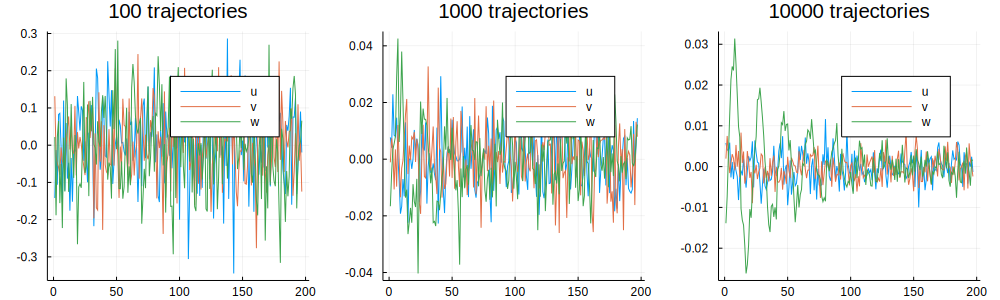

In [342]:
plot(p1, p2, p3, size=(1000, 300), layout=(1,3))

The plot above shows that a lot of trajectories (~ 10 k) are needed to actually tell the oscillations from the noise.

In [4]:
# Experimental parameters
T1 = 15.0
TD = 5.0
Trabi = 2.
Tphi = 17.9

NTrajectories = 300

# Parameter dictionary to be passed to the functions
params = Dict( :Tfinal    => 20., # Final time
               :dt        => 0.1, # duration of infinitesimal time
               :Gamma1    => 1. / T1,   # Gamma fluoresence
               :GammaD    => 1. / TD,  # Gamma dephasing controllable
               :GammaPhi  => 1. / Tphi,  # Gamma dephasing not controllable
               :etavalF   => 0.14, # efficiency fluoresence heterodyne
               :etavalD   => 0.34, # efficiency dephasing homodyne
               :omegaTrue => 2 * pi / Trabi, # True value of omega
               :omegaMin  => 2., # minimum value of omega
               :omegaMax  => 4., # maximum value of omega
               :threshold => 0.375,
               :Nomega    => 500); # Resolution in omega for the Bayesian estimation

In [44]:
(dyHet1, dyHet2, dyDep) = rescale_experimental_data(sample_data_chunk(NTrajectories))
@time res = Likelihood(dyHet1, dyHet2, dyDep, 200; params...); 

N trajectories: 500
 14.716423 seconds (55.23 M allocations: 6.311 GiB, 12.71% gc time)


In [346]:
print("Final estimation: $(res.omegaEst[end]) (true $(params[:omegaTrue]))" )

Final estimation: 3.106654548410887 (true 3.141592653589793)

We now check that the estimation works with the simulated experiment

In [348]:
@time simData = parallel_fluo_continuous_measurement_het_simulation(500; params...) 
@time simRes = Likelihood(simData.dyHet1, simData.dyHet2, simData.dyDep, 200; params...);

  1.237719 seconds (1.49 M allocations: 94.035 MiB, 5.25% gc time)
N trajectories: 500
 30.158052 seconds (52.46 M allocations: 6.175 GiB, 63.20% gc time)


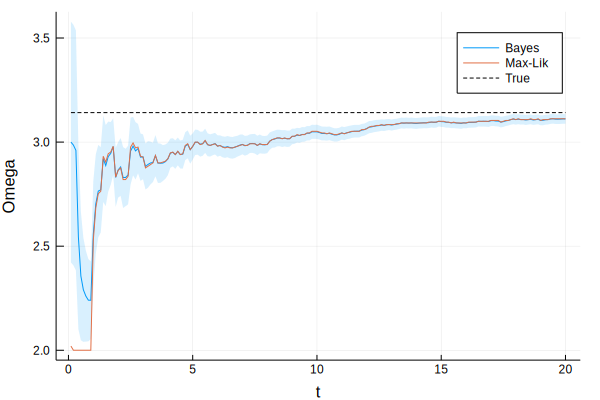

In [350]:
plot( simRes.t, simRes.omegaEst, ribbon=(simRes.sigmaBayes, simRes.sigmaBayes), fillalpha=0.15, label="Bayes")
xlabel!("t")
ylabel!("Omega")
plot!(simRes.t, simRes.omegaMaxLik, label="Max-Lik")
plot!(simRes.t, fill(params[:omegaTrue], size(simRes.t)), style=:dash, color=:black, label="True")

Let's compare the Fisher information with our Bayesian variance

In [ ]:
### params_unconditional = copy(params)
params_unconditional[:etavalF] = 0.
params_unconditional[:etavalD] = 0.

#(tFisher, FisherAvgUncOmega15, QFisherAvgUncOmega15, FisherMAvgUncOmega15, QFisherEffUNCOmega15, FisherMEffUNCOmega15)
@time fisherUncResult = parallel_fluo_continuous_measurement_het_classic_initial0(10; Ntime=1000, params_unconditional...)
@time fisherResult = parallel_fluo_continuous_measurement_het_classic_initial0(5000; Ntime=1000, params...);

In [43]:
plot(fisherUncResult.t, fisherUncResult.QFisherEff, label="QFI uncond", legend=:topleft)
plot!(fisherResult.t, fisherResult.QFisherEff, label="Eff QFI (monitoring + strong m.)")
plot!(fisherResult.t, fisherResult.FisherAvg, label="FI monitoring")
plot!(res.t, res.sigmaBayes .^ -2 ./ NTrajectories, label="Inv. Bayesian variance (renorm.)")
xlabel!("t")

UndefVarError: UndefVarError: res not defined

## Strong measurement

The histogram belows shows how the data collected from the final $z$ measurement looks like.
There are two peaks which correspond to the values $\pm 1$ of the measurement, but they have a width. We need to decide to which measurement result the intermediate values belong.

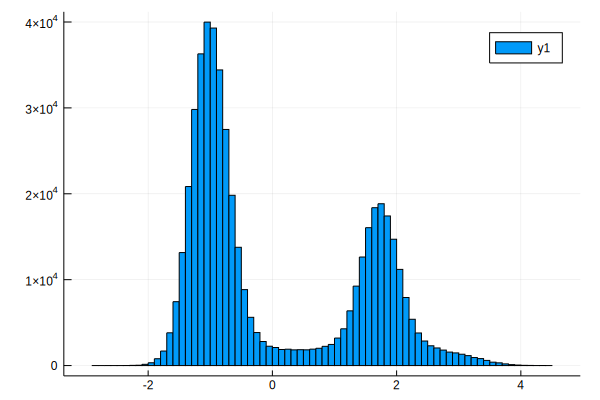

In [353]:
histogram(file["z"][:,1])

Let's load all the data with the final $z$ measurement. They are chunks of 10k trajectories every 30k. The function `load_z_data` returns a `NamedTuple` with the (rescaled) currents and the strong measurement output.

In [77]:
NTrajectories = 500
# The commmented lines use different ways of picking trajectories
#(dyHet1, dyHet2, dyDep, OutZ) = sample_data_chunk(NTrajectories, u_data, v_data, w_data, file["z"])
#(dyHet1, dyHet2, dyDep, OutZ) = get_data_chunk(1, 300, u_data, v_data, w_data, file["z"])
#(dyHet1, dyHet2, dyDep) = rescale_experimental_data((dyHet1, dyHet2, dyDep))
using Random
Random.seed!(6)
sample_traj = sample_data(NTrajectories, data);

In [78]:
@time resStrong = likelihood_strong(sample_traj.dyHet1, sample_traj.dyHet2, sample_traj.dyDep, sample_traj.OutZ, 200; params...);
#@time res = Likelihood(dyHet1, dyHet2, dyDep, 200; params...);

 12.475302 seconds (51.84 M allocations: 6.213 GiB, 14.78% gc time)


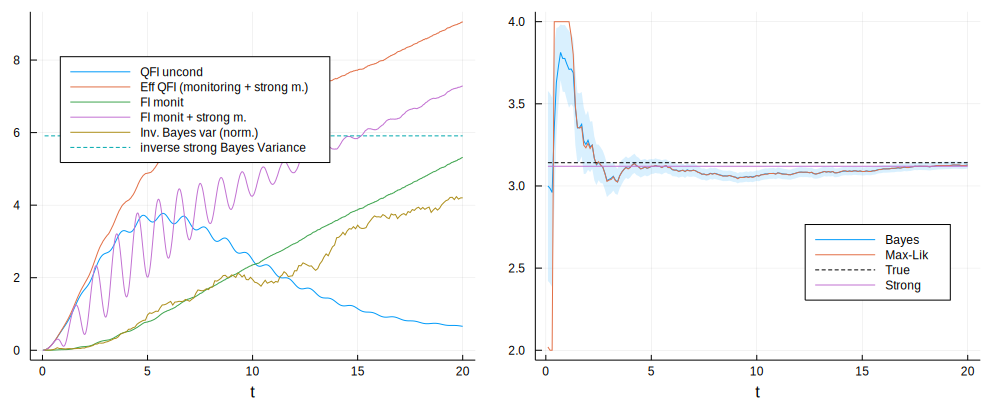

In [81]:
p1 = plot(fisherUncResult.t, fisherUncResult.QFisherEff, label="QFI uncond", legend=:topleft)
plot!(fisherResult.t, fisherResult.QFisherEff, label="Eff QFI (monitoring + strong m.)")
plot!(fisherResult.t,  fisherResult.FisherAvg, label="FI monit")
plot!(fisherResult.t, fisherResult.FisherMEff, label="FI monit + strong m.")
plot!(resStrong.t, resStrong.sigmaBayes .^ -2 ./ NTrajectories, label="Inv. Bayes var (norm.)")
plot!(resStrong.t, fill(1. / (NTrajectories*(resStrong.sigmaStrong[NTrajectories]^2)), size(res.t)), style=:dash, label="inverse strong Bayes Variance")
xlabel!("t")

p2 = plot( resStrong.t, resStrong.omegaEst, ribbon=(resStrong.sigmaBayes, resStrong.sigmaBayes), fillalpha=0.15, label="Bayes",legend=:bottomright)
plot!(resStrong.t, resStrong.omegaMaxLik, label="Max-Lik")
plot!(resStrong.t, fill(params[:omegaTrue], size(resStrong.t)), style=:dash,  color=:black, label="True")
plot!(resStrong.t, fill(resStrong.omegaEstStrong[end], size(resStrong.t)), fillalpha=0.15, label="Strong")
xlabel!("t")
plot(p1, p2, size=(1000,400), layout=2)

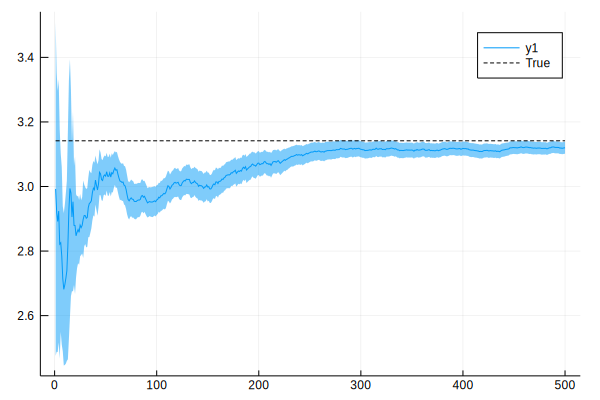

In [86]:
plot(resStrong.omegaEstStrong, ribbon=(resStrong.sigmaStrong, resStrong.sigmaStrong))
plot!(1:NTrajectories, fill(params[:omegaTrue], NTrajectories), style=:dash,  color=:black, label="True")

In [26]:
# How much does the threshold affect the final strong measurement estimation?
thres_params = copy(params)
thres_params[:threshold] = 0.5
@time resStrong = likelihood_strong(sample_traj.dyHet1, sample_traj.dyHet2, sample_traj.dyDep, sample_traj.OutZ, 200; thres_params...);

N trajectories: 300
  7.043081 seconds (31.15 M allocations: 3.731 GiB, 10.23% gc time)


In [61]:
@everywhere function omegaestVsThreshold(args)
    thres_param = args[1]
    sample_traj = args[2]
    resStrong = likelihood_strong(sample_traj.dyHet1, sample_traj.dyHet2, sample_traj.dyDep, sample_traj.OutZ, 200; thres_param...);
    return resStrong.omegaEstStrong[end]
end

In [62]:
NTrajectories = 500

a = [begin 
        thres_param = copy(params)
        thres_param[:threshold] = thres
        (thres_param, sample_traj)
        end for thres in -0.5:0.05:1.5];

omegaestVsThresholdData = pmap(omegaestVsThreshold, a);

41-element Array{Float64,1}:
 3.107208203378603 
 3.1079519866070355
 3.108020479506757 
 3.1084609739685414
 3.1084609739685414
 3.1067372246383638
 3.1079855991287815
 3.1079855991287815
 3.1079551297593873
 3.1082629272559674
 3.1087085268017587
 3.1094843884018433
 3.111172918559686 
 ⋮                 
 3.115459357738157 
 3.115459357738157 
 3.1159606970859093
 3.1165323922062345
 3.1162769384456848
 3.1157579438941885
 3.1150360864642432
 3.1158210513326114
 3.119203778802956 
 3.1175108242027374
 3.117397305512082 
 3.1228323922003263

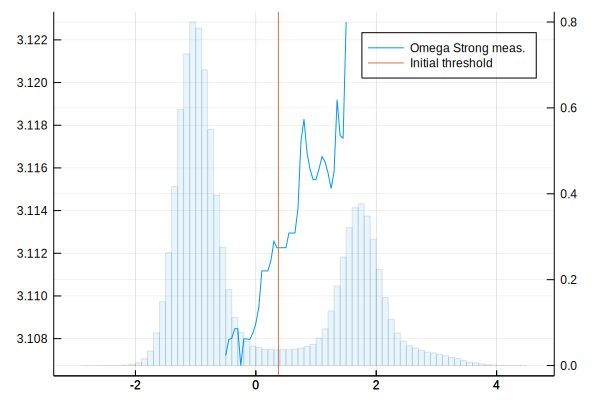

In [73]:
p1 = plot(-0.5:0.05:1.5, omegaestVsThresholdData, label="Omega Strong meas.")
vline!([.375], label="Initial threshold")
p1_shared = twinx(p1)
histogram!(p1_shared, file["z"][:,1],normalize=true, alpha=.1, legend=:none)

The plot above shows the estimated value of $\Omega$ as a function of the threshold for the strong measurement, for the same sample of 500 trajectories. Moving the threshold between 0 and 0.5 affects the third digit.

### 5k trajectories

In [91]:
NTrajectories = 5000
# The commmented lines use different ways of picking trajectories
#(dyHet1, dyHet2, dyDep, OutZ) = sample_data_chunk(NTrajectories, u_data, v_data, w_data, file["z"])
#(dyHet1, dyHet2, dyDep, OutZ) = get_data_chunk(1, 300, u_data, v_data, w_data, file["z"])
#(dyHet1, dyHet2, dyDep) = rescale_experimental_data((dyHet1, dyHet2, dyDep))
using Random
Random.seed!(95)
sample_traj = sample_data(NTrajectories, data);

In [92]:
# 2 minutes on qtech
@time resStrong5k = likelihood_strong(sample_traj.dyHet1, sample_traj.dyHet2, sample_traj.dyDep, sample_traj.OutZ, 200; params...);
#@time res = Likelihood(dyHet1, dyHet2, dyDep, 200; params...);

119.435118 seconds (517.18 M allocations: 62.055 GiB, 12.60% gc time)


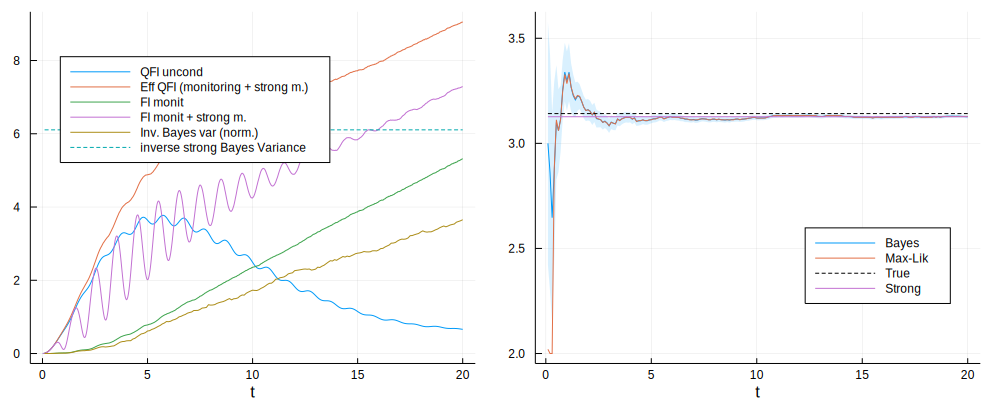

In [93]:
let resStrong = resStrong5k
p1 = plot(fisherUncResult.t, fisherUncResult.QFisherEff, label="QFI uncond", legend=:topleft)
plot!(fisherResult.t, fisherResult.QFisherEff, label="Eff QFI (monitoring + strong m.)")
plot!(fisherResult.t,  fisherResult.FisherAvg, label="FI monit")
plot!(fisherResult.t, fisherResult.FisherMEff, label="FI monit + strong m.")
plot!(resStrong.t, resStrong.sigmaBayes .^ -2 ./ NTrajectories, label="Inv. Bayes var (norm.)")
plot!(resStrong.t, fill(1. / (NTrajectories*(resStrong.sigmaStrong[NTrajectories]^2)), size(res.t)), style=:dash, label="inverse strong Bayes Variance")
xlabel!("t")

p2 = plot( resStrong.t, resStrong.omegaEst, ribbon=(resStrong.sigmaBayes, resStrong.sigmaBayes), fillalpha=0.15, label="Bayes",legend=:bottomright)
plot!(resStrong.t, resStrong.omegaMaxLik, label="Max-Lik")
plot!(resStrong.t, fill(params[:omegaTrue], size(resStrong.t)), style=:dash,  color=:black, label="True")
plot!(resStrong.t, fill(resStrong.omegaEstStrong[end], size(resStrong.t)), fillalpha=0.15, label="Strong")
xlabel!("t")
plot(p1, p2, size=(1000,400), layout=2)
end

There's still a bias, even with 5k trajectories. But the bounds are not violated

### 10k trajectories

In [97]:
NTrajectories = 10000
# The commmented lines use different ways of picking trajectories
#(dyHet1, dyHet2, dyDep, OutZ) = sample_data_chunk(NTrajectories, u_data, v_data, w_data, file["z"])
#(dyHet1, dyHet2, dyDep, OutZ) = get_data_chunk(1, 300, u_data, v_data, w_data, file["z"])
#(dyHet1, dyHet2, dyDep) = rescale_experimental_data((dyHet1, dyHet2, dyDep))
using Random
Random.seed!(465)
sample_traj = sample_data(NTrajectories, data);

In [98]:
@time resStrong10k = likelihood_strong(sample_traj.dyHet1, sample_traj.dyHet2, sample_traj.dyDep, sample_traj.OutZ, 200; params...);

250.194706 seconds (1.03 G allocations: 124.102 GiB, 12.70% gc time)


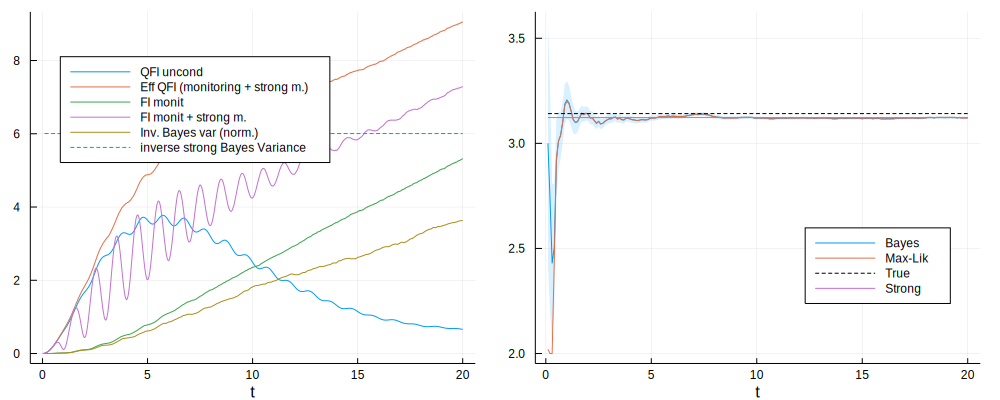

In [99]:
let resStrong = resStrong10k
p1 = plot(fisherUncResult.t, fisherUncResult.QFisherEff, label="QFI uncond", legend=:topleft)
plot!(fisherResult.t, fisherResult.QFisherEff, label="Eff QFI (monitoring + strong m.)")
plot!(fisherResult.t,  fisherResult.FisherAvg, label="FI monit")
plot!(fisherResult.t, fisherResult.FisherMEff, label="FI monit + strong m.")
plot!(resStrong.t, resStrong.sigmaBayes .^ -2 ./ NTrajectories, label="Inv. Bayes var (norm.)")
plot!(resStrong.t, fill(1. / (NTrajectories*(resStrong.sigmaStrong[NTrajectories]^2)), size(res.t)), style=:dash, label="inverse strong Bayes Variance")
xlabel!("t")

p2 = plot( resStrong.t, resStrong.omegaEst, ribbon=(resStrong.sigmaBayes, resStrong.sigmaBayes), fillalpha=0.15, label="Bayes",legend=:bottomright)
plot!(resStrong.t, resStrong.omegaMaxLik, label="Max-Lik")
plot!(resStrong.t, fill(params[:omegaTrue], size(resStrong.t)), style=:dash,  color=:black, label="True")
plot!(resStrong.t, fill(resStrong.omegaEstStrong[end], size(resStrong.t)), fillalpha=0.15, label="Strong")
xlabel!("t")
plot(p1, p2, size=(1000,400), layout=2)
end

## Simulations
I would like to check what happens if I simulate smaller dt

In [132]:
simParams = copy(params)
simParams[:dt] = 0.01
NTrajectories = 2000
@time simData = parallel_fluo_continuous_measurement_het_simulation(NTrajectories; simParams...) 

 10.175552 seconds (23.47 k allocations: 1.007 MiB)


(t = 0.01:0.01:20.0, Ntime = 2000, dyHet1 = [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.094449 0.0853256 … -0.0412439 -0.0991118; -0.120369 0.028587 … -0.0214137 -0.00850365], dyHet2 = [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; -0.197853 0.105548 … -0.093814 -0.100354; -0.0425085 0.0480553 … 0.124833 -0.0922458], dyDep = [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; -0.158257 -0.256157 … 0.0822338 -0.0777028; 0.0106538 0.0798098 … 0.0260429 -0.0854545], OutStrong = [-1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0; … ; -1.0 -1.0 … 1.0 1.0; -1.0 1.0 … 1.0 1.0], AvgZcondTrue = [-0.919599 -0.918292 … -0.702495 -0.693658; -0.919599 -0.918292 … 0.371317 0.401406; … ; -0.919599 -0.918292 … -0.191196 -0.176797; -0.919599 -0.918292 … 0.441858 0.429157])

In [133]:
include("continuous_measurement_bayes/likelihood.jl")
@time simRes = Likelihood(simData.dyHet1, simData.dyHet2, simData.dyDep, 2000; params...);

484.770661 seconds (2.05 G allocations: 245.092 GiB, 14.13% gc time)


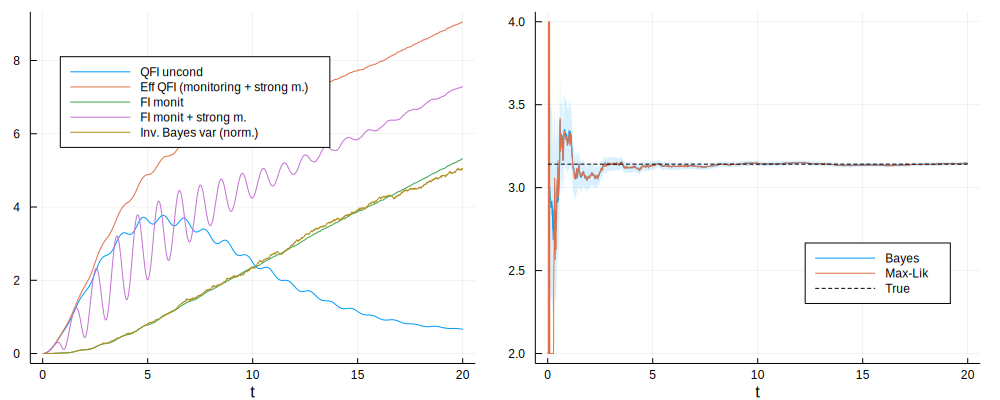

In [136]:
let resStrong = simRes
p1 = plot(fisherUncResult.t, fisherUncResult.QFisherEff, label="QFI uncond", legend=:topleft)
plot!(fisherResult.t, fisherResult.QFisherEff, label="Eff QFI (monitoring + strong m.)")
plot!(fisherResult.t,  fisherResult.FisherAvg, label="FI monit")
plot!(fisherResult.t, fisherResult.FisherMEff, label="FI monit + strong m.")
plot!(resStrong.t, resStrong.sigmaBayes .^ -2 ./ NTrajectories, label="Inv. Bayes var (norm.)")
#plot!(resStrong.t, fill(1. / (NTrajectories*(resStrong.sigmaStrong[NTrajectories]^2)), size(res.t)), style=:dash, label="inverse strong Bayes Variance")
xlabel!("t")

p2 = plot( resStrong.t, resStrong.omegaEst, ribbon=(resStrong.sigmaBayes, resStrong.sigmaBayes), fillalpha=0.15, label="Bayes",legend=:bottomright)
plot!(resStrong.t, resStrong.omegaMaxLik, label="Max-Lik")
plot!(resStrong.t, fill(params[:omegaTrue], size(resStrong.t)), style=:dash,  color=:black, label="True")
xlabel!("t")
plot(p1, p2, size=(1000,400), layout=2)
end